In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
from tqdm.autonotebook import tqdm
import os
import cftime
import json
from dask import array

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [26]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster.from_yaml('worker-spec.yml')
cluster.adapt(minimum=1, maximum=20, interval='2s')
client = Client(cluster)
client

TypeError: argument of type 'NoneType' is not iterable

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
gcs = gcsfs.GCSFileSystem(token='anon')

In [3]:
dfs = pd.read_csv('pangeo.csv')

In [35]:
def load_srch_data(df, source_id, expt_id):

    uri = df[(df.source_id == source_id) &
                         (df.experiment_id == expt_id)].zstore.values[0]
    
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

def load_data(series):
    ds = xr.open_zarr(gcs.get_mapper(series.zstore), consolidated=True)
    return ds

def get_dims(ds):
    ds_coords = [l for l in list(ds.coords.keys()) if 'bnds' not in l and 'vert' not in l]
    dims = [[l for l in ds_coords if 'lat' in l][0], [l for l in ds_coords if 'lon' in l][0]]
    lat = ds.coords.get(dims[0])
    lon = ds.coords.get(dims[1])
    return lat, lon, dims

def get_area(ds, df):
    var = ds.get(ds.variable_id)
    realm = ds.table_id[0].lower()
    lat, lon, dims = get_dims(ds)

    df_area = df.query("variable_id == 'areacell"+realm+"' & source_id == '"+ds.source_id+"' & grid_label== '"+ds.grid_label+"'")
    if len(df_area.zstore.values) == 0:
        if len(lat.data) > 2000:
            area = np.cos(lat * np.pi / 180)
            dims = ["ncells"]
            total_area = lat.sum()
        elif np.shape(lat) == np.shape(var)[1:]:
            area = np.cos(lat.data * np.pi / 180)
            total_area = area.sum()
            dims = ds.get(dims[0]).dims
        else:
            time, area, lon = np.meshgrid(ds.time, np.cos(lat.data * np.pi / 180), lon, indexing='ij')
            total_area = area[0,:,:].sum()
    else:
        ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
        area = ds_area.get("areacell"+realm)
        total_area = area.sum(area.dims)
        dims = area.dims

    return area, dims, total_area

def avg_var(ds, df):
    area, dims, total_area = get_area(ds, df)
    var = ds.get(ds.variable_id)
    
    ta_timeseries = (var * area).sum(dim=dims) / total_area
    
    if isinstance(ta_timeseries, type(None)):
        print('failed')
    return ta_timeseries



In [36]:
results = {}

In [37]:
for num in tqdm(list(range(len(dfs)))):
    s = dfs.iloc[num]
    name = '_'.join([s.source_id, s.experiment_id, s.member_id, s.variable_id])
    
    ds = load_data(s)
    df_area = df.query("variable_id == 'areacell"+ds.table_id[0].lower()+"' & source_id == '"+ds.source_id+"' & grid_label== '"+ds.grid_label+"'")
    if len(df_area.zstore.values != 0):
        continue
        
    print(str(num)+" : "+name)

    if ds.experiment_id == 'piControl' or ds.experiment_id == '1pctCO2':
        ds = ds.sel(time=slice(ds.time[0], ds.time[min([1799, len(ds.time)-1])]))
    elif len(ds.time) > 2400:
        ds = ds.sel(time=slice(ds.time[0], ds.time[2399]))
    m = avg_var(ds, df)

    if not isinstance(m, type(None)):
        np.save('data/'+name, np.array([m.values[:], np.array([np.datetime64(t) for t in m.time.values])[:]]))

0 : AWI-CM-1-1-MR_1pctCO2_r1i1p1f1_rlut
1 : AWI-CM-1-1-MR_1pctCO2_r1i1p1f1_rsut
2 : AWI-CM-1-1-MR_1pctCO2_r1i1p1f1_ts
3 : AWI-CM-1-1-MR_1pctCO2_r1i1p1f1_tos
4 : AWI-CM-1-1-MR_abrupt-4xCO2_r1i1p1f1_rlut
5 : AWI-CM-1-1-MR_abrupt-4xCO2_r1i1p1f1_rsdt
6 : AWI-CM-1-1-MR_abrupt-4xCO2_r1i1p1f1_rsut
7 : AWI-CM-1-1-MR_abrupt-4xCO2_r1i1p1f1_ts
8 : AWI-CM-1-1-MR_abrupt-4xCO2_r1i1p1f1_tos
9 : BCC-CSM2-MR_1pctCO2_r1i1p1f1_ts
10 : BCC-CSM2-MR_1pctCO2_r1i1p1f1_tos
11 : BCC-CSM2-MR_abrupt-4xCO2_r1i1p1f1_ts
12 : BCC-CSM2-MR_abrupt-4xCO2_r1i1p1f1_tos
13 : BCC-CSM2-MR_piControl_r1i1p1f1_ts
14 : BCC-CSM2-MR_piControl_r1i1p1f1_mlotst
15 : BCC-CSM2-MR_piControl_r1i1p1f1_tos
23 : CAMS-CSM1-0_1pctCO2_r1i1p1f1_rlut
24 : CAMS-CSM1-0_1pctCO2_r1i1p1f1_rsdt
25 : CAMS-CSM1-0_1pctCO2_r1i1p1f1_rsut
26 : CAMS-CSM1-0_1pctCO2_r1i1p1f1_ts
28 : CAMS-CSM1-0_1pctCO2_r2i1p1f1_rlut
29 : CAMS-CSM1-0_1pctCO2_r2i1p1f1_rsdt
30 : CAMS-CSM1-0_1pctCO2_r2i1p1f1_rsut
31 : CAMS-CSM1-0_1pctCO2_r2i1p1f1_ts
33 : CAMS-CSM1-0_abrupt-4xCO2_r1

/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/tim

104 : CNRM-CM6-1_piControl_r1i1p1f2_tos


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/tim

143 : CNRM-ESM2-1_piControl_r1i1p1f2_tos


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


159 : E3SM-1-0_1pctCO2_r1i1p1f1_mlotst
160 : E3SM-1-0_1pctCO2_r1i1p1f1_tos
162 : E3SM-1-1_piControl_r1i1p1f1_mlotst
163 : E3SM-1-1_piControl_r1i1p1f1_tos
164 : EC-Earth3-Veg_1pctCO2_r1i1p1f1_ts
167 : EC-Earth3-Veg_abrupt-4xCO2_r1i1p1f1_ts


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


169 : EC-Earth3-Veg_piControl_r1i1p1f1_ts


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/tim

172 : EC-Earth3_piControl_r1i1p1f1_ts


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/tim

222 : HadGEM3-GC31-MM_piControl_r1i1p1f1_mlotst
223 : HadGEM3-GC31-MM_piControl_r1i1p1f1_tos


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/tim

259 : MRI-ESM2-0_1pctCO2_r1i1p1f1_tos
269 : MRI-ESM2-0_abrupt-4xCO2_r10i1p1f1_tos


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/tim

325 : MRI-ESM2-0_piControl_r1i1p1f1_tos
359 : GISS-E2-2-G_1pctCO2_r1i1p1f1_ts
360 : GISS-E2-2-G_1pctCO2_r1i1p1f1_tos
361 : GISS-E2-2-G_piControl_r1i1p1f1_ts
362 : GISS-E2-2-G_piControl_r1i1p1f1_mlotst
363 : GISS-E2-2-G_piControl_r1i1p1f1_tos
416 : NESM3_1pctCO2_r1i1p1f1_rlut
417 : NESM3_1pctCO2_r1i1p1f1_rsdt
418 : NESM3_1pctCO2_r1i1p1f1_rsut
419 : NESM3_1pctCO2_r1i1p1f1_ts
420 : NESM3_1pctCO2_r1i1p1f1_mlotst
421 : NESM3_1pctCO2_r1i1p1f1_tos
422 : NESM3_abrupt-4xCO2_r1i1p1f1_rlut
423 : NESM3_abrupt-4xCO2_r1i1p1f1_rsdt
424 : NESM3_abrupt-4xCO2_r1i1p1f1_rsut
425 : NESM3_abrupt-4xCO2_r1i1p1f1_ts
426 : NESM3_abrupt-4xCO2_r1i1p1f1_mlotst
427 : NESM3_abrupt-4xCO2_r1i1p1f1_tos


/srv/conda/envs/notebook/lib/python3.6/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.6/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


428 : NESM3_piControl_r1i1p1f1_ts
429 : NESM3_piControl_r1i1p1f1_mlotst
430 : NESM3_piControl_r1i1p1f1_tos



In [10]:
ds = load_data(dfs.iloc[3])
var = ds.get(ds.variable_id)
# realm = ds.table_id[0].lower()
# df_area = df.query("variable_id == 'areacell"+realm+"' & source_id == '"+ds.source_id+"' & grid_label == '"+ds.experiment_id+"'")
# ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
# area = ds_area.get("areacell"+realm)
lat, lon, dims = get_dims(ds)

In [29]:
w = (var * np.cos(lat.data * np.pi / 180)).sum(dim='ncells') / np.cos(lat.data * np.pi / 180).sum()

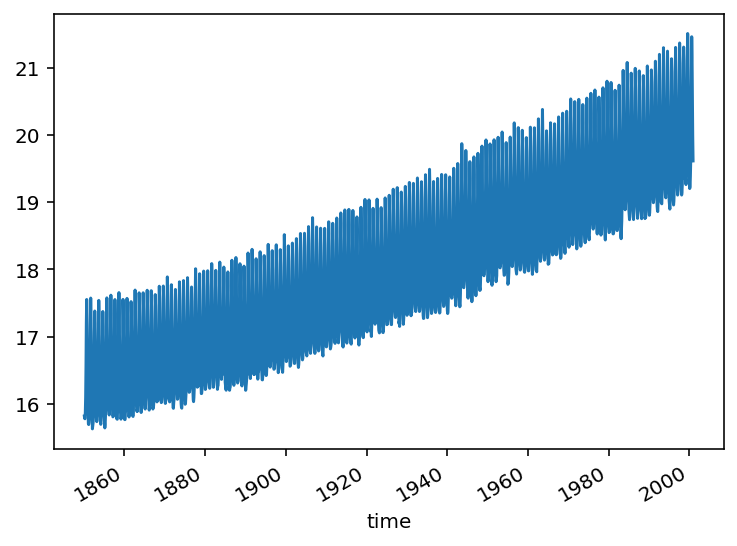

In [30]:
w.plot()

In [28]:
lat.data.compute()

array([-47.39407752, -48.47549908, -49.20522144, ...,  59.96596739,
        33.4582047 ,  42.16660379])

In [31]:
df_area = df.query("variable_id == 'areacello' & source_id == '"+ds.source_id+"' & grid_label== '"+ds.grid_label+"'")


In [32]:
df_area

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year


In [33]:
len(lat)

830305

In [34]:
len(lon)

830305